In [135]:
# Step 1

class Multinomial_NB: 
    
    def _init_(self, alpha=1.0):
        self.alpha = alpha

    def fit(self, X, Y):
        self.row, self.column = X.shape
        self.c, self.cCount = np.unique(Y, return_counts=True)
        numberOfClass = len(self.c)    
        numberTerms = len(np.unique(X[:, 2]))

        # Find prior
        self.prior = np.zeros(numberOfClass)
        for i, c in enumerate(self.c):
            numberSample = X[np.where(Y == c)]
            self.prior[i] = ((numberSample.shape[0] + self.alpha) / (numberOfClass * self.alpha + self.row))

        # Find likelihood
        self.likelihood = {i:{} for i in range(self.column)}
        for j in range(self.column):
            for c in range(numberOfClass):
                feature, featureCounts = np.unique(X[np.where(Y == c), j], return_counts=True)
                probabilityArray = (featureCounts + self.alpha) / (numberTerms * self.alpha + self.cCount[c])
                dictionary = {feature[k]: probabilityArray[k] for k in range(len(feature))}
                dictionary['NotExist'] = self.alpha/(numberTerms * self.alpha + self.cCount[c])
                self.likelihood[j][self.c[c]] = dictionary
              
    def predict(self, X):
        return self.predict_log_proba(X)
                
    def predict_log_proba(self, X):
        posterior = []
        row, column = X.shape
        
        for i in range(row):
            maximum = 0
            label = None
            for j in range(len(self.prior)):
                log_prior = self.prior[j]
                normalize = 1
                for k in range(column):
                    status = self.likelihood[k][j].get(X[i, k])
                    # if status is NONE
                    if status:
                        normalize *= status
                    else:
                        normalize *= self.likelihood[k][j]['NotExist']
                log_posterior = log_prior * normalize

                if log_posterior > maximum:
                    maximum = log_posterior
                    label = j
            posterior.append(label)
                
        return posterior
    
    def predict_proba(self, X):
        return pow(2, self.predict_log_proba(X))

In [73]:
# Step 2

import pandas as pd

df = pd.read_csv('SMSSpamCollection', sep='\t', names=['label','sms_message'])
df.head()

,label,sms_message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [74]:
# Step 3

df['length'] = df['sms_message'].map(lambda text: len(text))

df.groupby('label').length.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
ham,4825.0,71.482487,58.440652,2.0,33.0,52.0,93.0,910.0
spam,747.0,138.670683,28.873603,13.0,133.0,149.0,157.0,223.0


In [75]:
# Step 3

df['label'] = df.label.map({'ham':0, 'spam':1})
df.head()

,label,sms_message,length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


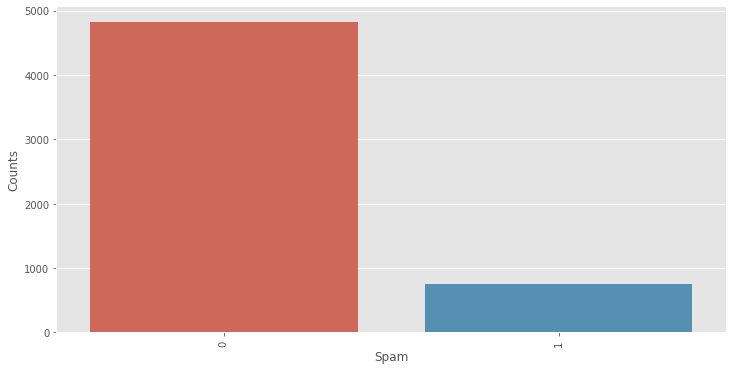

In [76]:
# Step 4
# 0 ham, 1 spam

import seaborn as sns
import matplotlib.pyplot as plt
 
label_counts = df.label.value_counts()
plt.figure(figsize = (12,6))
sns.barplot(label_counts.index, label_counts.values, alpha = 0.9)

plt.xticks(rotation = 'vertical')
plt.xlabel('Spam', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()

In [77]:
#Step 5

In [78]:
%%time
# import ssl
# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context

import nltk
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

df['text_lemmatized'] = df['sms_message'].map(lambda text: ' '.join(lemmatizer.lemmatize(w) for w in nltk.word_tokenize(text.lower())))

[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1123)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1123)>


CPU times: user 4.66 s, sys: 174 ms, total: 4.83 s
Wall time: 5.55 s


In [79]:
print(df['sms_message'][2])
print("\nLemmatized Email:\n")
print(df['text_lemmatized'][2])

Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

Lemmatized Email:

free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005. text fa to 87121 to receive entry question ( std txt rate ) t & c 's apply 08452810075over18 's


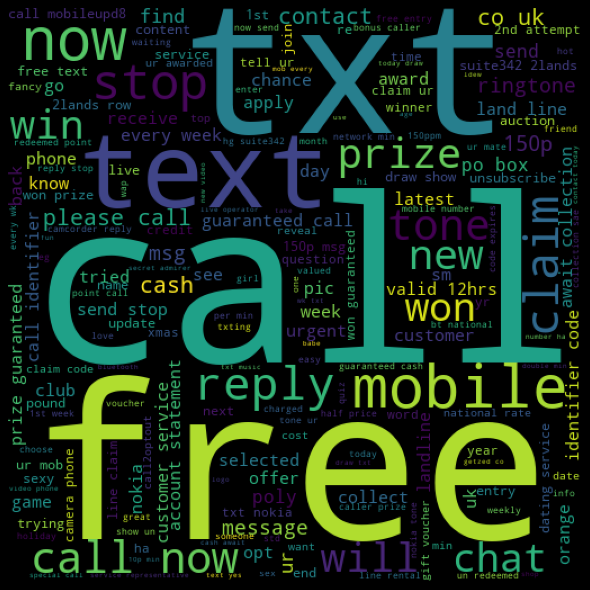

In [80]:
#Step 6
from wordcloud import WordCloud

#for spam messages
spam_words = ''.join(list(df[df['label']==1]['text_lemmatized']))
spam_wordclod = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wordclod)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

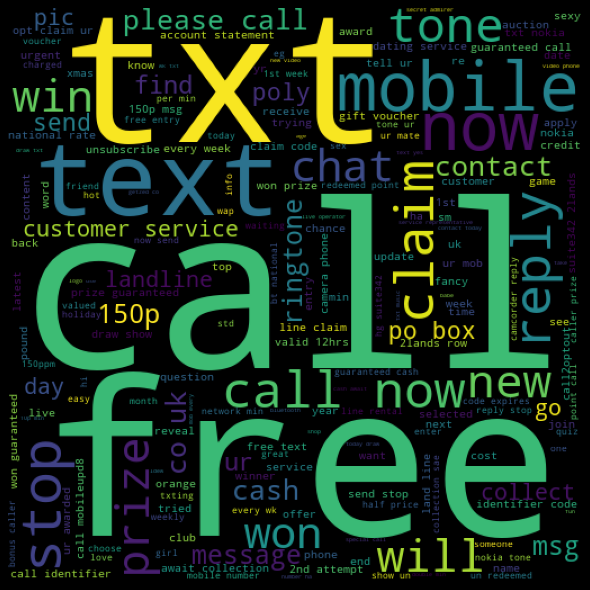

In [81]:
#Step 6

from wordcloud import WordCloud

#for spam messages
spam_words = ''.join(list(df[df['label']==1]['text_lemmatized']))
spam_wordclod = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wordclod)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

In [82]:
# Step 7
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

documents = df['text_lemmatized']

count_vect = CountVectorizer(lowercase=True, stop_words='english')
document_counts = count_vect.fit_transform(documents)

documents = np.array(documents)

# print("\nFeature Names:")
# print(count_vect.get_feature_names())

# print("\nVocabulary: ", count_vect.vocabulary_)


print("\nCount Vector Matrix (Dense Matrix):")
print(document_counts.toarray())

print(document_counts.shape)


Count Vector Matrix (Dense Matrix):
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(5572, 7935)


In [83]:
# Step 8

X = df['text_lemmatized']
y = df['label']

print(X.shape)
print(y.shape)

(5572,)
(5572,)


In [84]:
# Step 9
df = df.sample(frac=1) 
df.head()

,label,sms_message,length,text_lemmatized
3955,0,I probably won't eat at all today. I think I'm...,94,i probably wo n't eat at all today . i think i...
5036,0,How many times i told in the stage all use to ...,72,how many time i told in the stage all use to l...
5424,0,U horrible gal... U knew dat i was going out w...,84,u horrible gal ... u knew dat i wa going out w...
4172,0,Pls what's the full name of joke's school cos ...,124,pls what 's the full name of joke 's school co...
1300,0,Great to hear you are settling well. So what's...,64,great to hear you are settling well . so what ...


In [85]:
#Step 10

# Splitting the data into Train Set and Test Set
def partition(X,y,t):
    x_train = np.array(X[int((len(X)+1)*t):])
    x_test = np.array(X[:int((len(X)+1)*t)])
    y_train = np.array(y[int((len(y)+1)*t):])
    y_test = np.array(y[:int((len(y)+1)*t)]) 
    return x_train, x_test, y_train, y_test

#separate the target vector and features
def separateTargetVector(dataSet):
    y = dataSet['label'] #target vector
    X = dataSet.drop(columns='label') #features matrix
    t = 0.2
    return X,y,t

#a function to split data into partition
#according to the number of folds
def partitionSplit(df, folds):
    s_partition = []
    dfCopy = df
    #set the size for each partiton
    eachPartition = int(df.shape[0] / folds)
    for i in range(folds):
        partition = []
        #going through each partition
        for j in range(eachPartition):
            if(len(partition) < eachPartition):
                value = dfCopy.index[0]
                partition.append(value.tolist())
                dfCopy = dfCopy.drop(value)
        s_partition.append((np.asarray(partition)).tolist())
  
    return s_partition


In [86]:
# Functions for Part D

# Returns the Accuracy
def accuracy(predicted, actual):
    accuracy = sum(np.array(predicted) == np.array(actual)) / float(len(actual))
    return accuracy

# Calculates Precision Values when inputs are TP and FP 
# that are based upon the probability and threshold
def precisions(tp, fp):
    score = []
    for i in range(len(tp)):
        precision = tp[i] / (tp[i] + fp[i])
        i += 1
        score.append(precision)
    return score

# Calculates Recall Values when inputs are TP and FN 
# that are based upon the probability and threshold
def recalls(tp, fn):
    score = []
    for i in range(len(tp)):
        recall = tp[i] / (tp[i] + fn[i])
        i += 1
        score.append(recall)
    return score


# Calculates Precision Score when input arguments are Test Labels and the 
# predicted labels
def precisionScore(yTest, yPredict):
    tp = sum((np.array(yTest) == 1) & (np.array(yPredict) == 1))
    fp = sum((np.array(yTest) == 0) & (np.array(yPredict) == 1))
    score = tp/(tp+fp)
    return score

# Calculates Recall Score when input arguments are Test Labels and the 
# predicted labels
def recallScore(yTest, yPredict):
    tp = sum((np.array(yTest) == 1) & (np.array(yPredict) == 1))
    fn = sum((np.array(yTest) == 1) & (np.array(yPredict) == 0))
    score = tp/(tp+fn)
    return score

# Calculates F1 Score when input arguments are Test Labels and the 
# predicted labels
def f1_score(yTest, yPredict):
    tp = sum((np.array(yTest) == 1) & (np.array(yPredict) == 1))
    fn = sum((np.array(yTest) == 1) & (np.array(yPredict) == 0))
    fp = sum((np.array(yTest) == 0) & (np.array(yPredict) == 1))
    score = tp / (tp + ((fn + fp) / 2))
    return score

# Generates the Confusion Matrix
def confusionMatrix(actual, predicted):
    confusionLists = np.unique(actual)
    matrixSize = len(confusionLists)
    matrix = np.zeros((matrixSize, matrixSize))
    for i in range (matrixSize):
        for j in range (matrixSize):
            matrix[i, j] = np.sum((actual == confusionLists[i]) & (predicted == confusionLists[j]))
    return matrix

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

# Generates the ROC Curve

def roc_curve(yTest, probability, label=None):
    fprList = []
    tprList = []
    
    thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

    fpValues = []
    fnValues = []
    tpValues = []
    tnValues = []

    # Getting a new array of predictions based on the thresholds and the
    # array of probabilities of "1: Good Wine" in KNN
    for j in range(len(thresholds)):
        newValues = []
        for i in range(len(probability)):
            if (probability[i] < thresholds[j]):
                newValues.append(0)
            else:
                newValues.append(1)
        for k in range(len(newValues)):
        
            tp = sum((np.array(yTest) == 1) & (np.array(newValues) == 1))
            fn = sum((np.array(yTest) == 1) & (np.array(newValues) == 0))
            fp = sum((np.array(yTest) == 0) & (np.array(newValues) == 1))
            tn = sum((np.array(yTest) == 0) & (np.array(newValues) == 0))

        tpValues.append(tp)
        fnValues.append(fn)
        fpValues.append(fp)
        tnValues.append(tn)

    for i in range(len(fpValues)):
        fpr = fpValues[i]/(fpValues[i]+tnValues[i]) #False Positive Rate
        tpr = tpValues[i]/(tpValues[i]+fnValues[i]) #True Positive Rate
        
        #put point by point into list
        fprList.append(fpr)
        tprList.append(tpr)
        
    print(fprList)
    print(tprList)
    
    #Plotting
    fig = plt.figure(figsize=(10, 6))
    plt.plot(fprList, tprList, color='darkorange', linewidth=8, label=label) 
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.axis([0, 1, 0, 1])
    plt.title('ROC Curve (Train Data)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()


# Generates the AUC values
def AUC(yTest, probability):
    fprList = []
    tprList = []
    
    thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

    fpValues = []
    fnValues = []
    tpValues = []
    tnValues = []

    # Getting a new array of predictions based on the thresholds and the
    # array of probabilities of "1: Good Wine" in KNN
    for j in range(len(thresholds)):
        newValues = []
        for i in range(len(probability)):
            if (probability[i] < thresholds[j]):
                newValues.append(0)
            else:
                newValues.append(1)
        for k in range(len(newValues)):
            tp = sum((np.array(yTest) == 1) & (np.array(newValues) == 1))
            fn = sum((np.array(yTest) == 1) & (np.array(newValues) == 0))
            fp = sum((np.array(yTest) == 0) & (np.array(newValues) == 1))
            tn = sum((np.array(yTest) == 0) & (np.array(newValues) == 0))

        tpValues.append(tp)
        fnValues.append(fn)
        fpValues.append(fp)
        tnValues.append(tn)

    for i in range(len(fpValues)):     
        fpr = fpValues[i]/(fpValues[i]+tnValues[i])
        tpr = tpValues[i]/(tpValues[i]+fnValues[i])
        #put point by point into list
        fprList.append(fpr)
        tprList.append(tpr)

    fprList = np.flip(fprList)
    tprList = np.flip(tprList)
    
    auc = np.trapz(tprList, fprList)
    
    return auc

In [107]:
#Step 11

def sFold(folds, data, labels, model, error_function, dictionary): 
    avgF1Score = [] 
    splitX = partitionSplit(data, folds)

    #loop to choose a partition as validation set
    for i, partition in enumerate(splitX):
        trainSet = list(splitX)
        del(trainSet[i])       #dropping the validation set
        trainSet = sum(trainSet, [])

        testSet = []           #getting the validation set 
        for row in partition:
            testSet.append(row)  #put data in validation set into a new list 
            
        #splitting the data into train and test set
        xTrainValues = []
        yTrainValues = []        
        for trainIndex in trainSet:
            xTrainValues.append(data.loc[trainIndex])
            yTrainValues.append(labels.loc[trainIndex])

        #splitting the validation set data into train and test set
        xTestValues = []
        yTestValues = []
        for testIndex in testSet:
            xTestValues.append(data.loc[testIndex])
            yTestValues.append(labels.loc[testIndex])
    
        #preform prediction using KNN
        if model == 'Multinomial_NB':
            modelClassifier = Multinomial_NB()
            modelClassifier._init_(alpha=dictionary.get('alpha'))
            modelClassifier.fit(np.array(xTrainValues), np.array(yTrainValues))
            yPredict = modelClassifier.predict(np.array(xTestValues))
            accuracy_value = accuracy(yPredict, np.array(yTestValues))
#             print('Accuracy: %.3f' %accuracy_value)
            
            #calculating the error using f1 score
            if error_function == 'f1':
                error = f1_score(np.array(yTestValues), yPredict)
                avgF1Score.append(error)
            
#             print('F1 Score: %.3f' %error)
#             print('\n')
      
    #get the average f1 score for the current k
    avgFinalF1Score = sum(avgF1Score) / len(avgF1Score) 
    print(avgFinalF1Score) 
    print('\n')

    return {'expected labels': yTestValues, 'predicted labels': yPredict, 'errors': [error]}

In [136]:
#get the X data(features without target) and y data(target column)
X,y,t = separateTargetVector(df)

#function to pass the hyperparameter into s-fold validation
def dictionary(alpha):
    modelArgs = dict()
    #form the dictionary
    for eachAlpha in alpha:
        modelArgs = {'alpha': eachAlpha}
        #use of s-folds
        out = sFold(5, X, y, 'Multinomial_NB', 'f1', modelArgs)

alpha = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0]

dictionary(alpha)

0.4490128010690352


0.44943173231061484


0.4589816542412417


0.5320310217083377


0.6181776052900889


0.5461215513064218


0.31945578901893307


0.25561994763038987




In [228]:
#Step 12

X,y,t = separateTargetVector(df)
xTrain, xTest, yTrain, yTest = partition(X, y, t)
modelClassifier = Multinomial_NB()
modelClassifier._init_(alpha=1.5)
modelClassifier.fit(np.array(xTrain), np.array(yTrain))
yPredict = modelClassifier.predict(np.array(xTest))
yPredict = np.array(yPredict)

# # Plot the ROC Curve
# print("ROC_curve:")
# roc_curve(yTest, probability)
# print("\n")

# # Get the AUC Value
# print("AUC_curve:")
# auc = AUC(yTest, probability)
# print("AUC: %f" %auc)
# print("\n")

[0.00024644 0.00024644 0.00024644 ... 0.00024644 0.00024644 0.00024644]
[0.00024644 0.00024644 0.00034501 0.00024644 0.00024644 0.00024644
 0.00024644 0.00024644 0.00024644 0.00024644 0.00024644 0.00024644
 0.00024644 0.00024644 0.00024644 0.00024644 0.00024644 0.00024644
 0.00024644 0.00024644 0.00024644 0.00024644 0.00024644 0.00024644
 0.00024644 0.00024644 0.00024644 0.00024644 0.00024644 0.00024644
 0.00024644 0.00024644 0.00024644 0.00024644 0.00024644 0.00024644
 0.00024644 0.00024644 0.00024644 0.00034501 0.00024644 0.00024644
 0.00024644 0.00024644 0.00024644 0.00024644 0.00024644 0.00024644
 0.00024644 0.00024644 0.00024644 0.00024644 0.00024644 0.00024644
 0.00024644 0.00024644 0.00024644 0.00024644 0.00024644 0.00024644
 0.00034501 0.00024644 0.00024644 0.00024644 0.00024644 0.00024644
 0.00024644 0.00024644 0.00024644 0.00024644 0.00024644 0.00024644
 0.00024644 0.00024644 0.00034501 0.00024644 0.00024644 0.00024644
 0.00024644 0.00024644 0.00024644 0.00024644 0.00024644 0

IndexError: index 2 is out of bounds for axis 0 with size 2

In [116]:
# Step 13

print('Precision:', precisionScore(yTest, yPredict))
print('Recall:', recallScore(yTest, yPredict))
print('F1 score:', f1_score(yTest, yPredict))
print('Accuracy:', accurary(yTest, yPredict))
print('Confusion Matrix:', confusionMatrix(yTest, yPredict))
print("\n")

Precision: 0.592391304347826
Recall: 0.6687116564417178
F1 score: 0.6282420749279539
Accuracy: 0.8842010771992819
Confusion Matrix: [[876.  75.]
 [ 54. 109.]]




In [120]:
# Step 15
def one_hot_labels(Y):
        # convert the vector of class indices into a matrix containing a one-hot vector for each instance.
    """
    Arguments:
        Y : ndarray
        1D array containing data with “int” type that represents class indices/labels.
    Returns:
        Y_one_hot : ndarray
        A matrix containing a one-hot vector for the Y of each instance. The
        number of rows is equal to the number of rows in Y. The number of
        columns is equal to the number of unique class indices/labels in Y (i.e., the
        number of classes).
    """
    unique_label = np.unique(Y)
    label_dict = {label: indice for indice, label in enumerate(unique_label)}
    Y_one_hot = np.zeros((len(Y), len(unique_label)))
    for i in range(len(Y)):
        Y_one_hot[i, label_dict[Y[i]]] = 1
    return Y_one_hot
    
    

In [118]:
# Step 16

def softmax(score):
    return np.exp(score)/sum(np.exp(score))
    

In [117]:
# Step 17

def cross_entropy_loss(Y_one_hot, Y_proba):
    return -(Y_one_hot*(np.log(Y_proba))).sum()
    

In [136]:
# Step 18

class Softmax_Regression:
    
    def __init__(self):
        self.Theta = None 
    
    def fit(self, X, Y, learning_rate=0.01, epochs=1000, tol=None, regularizer=None, lambd=0.0, early_stopping=False, validation_fraction=0.1, **kwargs):
        """
        Arguments:
            X : ndarray
                A numpy array with rows representing data samples and columns
                representing features.
            Y : ndarray
                A 1D numpy array with labels corresponding to each row of the feature
                matrix X.
            learning_rate : float
                It provides the step size for parameter update.
            epochs : int
                The maximum number of passes over the training data for updating the
                weight vector.
            tol : float or None
                The stopping criterion. If it is not None, the iterations will stop when
                (error > previous_error - tol). If it is None, the number of iterations will
                be set by the “epochs”.
            regularizer : string
                The string value could be one of the following: l1, l2, None.
                If it’s set to None, the cost function without the regularization term will
                be used for computing the gradient and updating the weight vector.
                However, if it’s set to l1 or l2, the appropriate regularized cost function
                needs to be used for computing the gradient and updating the weight
                vector.
            lambd : float
                It provides the regularization coefficient. It is used only when the
                “regularizer” is set to l1 or l2.
            early_stopping : Boolean, default=False
                Whether to use early stopping to terminate training when validation score
                is not improving. If set to True, it will automatically set aside a fraction
                of training data as validation and terminate training when validation
                score is not improving.
            validation_fraction : float, default=0.1
                The proportion of training data to set aside as validation set for early
                stopping. Must be between 0 and 1. Only used if early_stopping is True.
        """
        n, p = X.shape
        unique_labels = np.unique(Y)
        # The “Theta_hat” should be a matrix with dimension: no. of features (including bias) x no. of classes
        Theta_hat = np.zeros((p, len(unique_labels)))
        X = np.c_[np.ones((n,1)), X]
        Theta_hat = np.r_[np.ones((1, len(unique_labels))), Theta_hat]
        Y_one_hot = one_hot_labels(Y)
        previous_error = None
        for i in range(epochs):
            Y_proba = softmax(X@Theta_hat)
            if not regularizer:
                cost = cross_entropy_loss(Y_one_hot, Y_proba)/n
                Theta_hat -= learning_rate*X.T@(Y_proba-Y_one_hot)/n
            elif regularizer == 'l1':
                cost = (cross_entropy_loss(Y_one_hot, Y_proba)+lambd*np.sum(abs(Theta_hat)))/n
                Theta_hat -= (learning_rate*X.T@(Y_proba-Y_one_hot)+lambd)/n
            elif regularizer == 'l2':
                cost = (cross_entropy_loss(Y_one_hot, Y_proba)+lambd*np.sum(Theta_hat**2))/n
                Theta_hat -= (learning_rate*X.T@(Y_proba-Y_one_hot)+2*lambd*Theta_hat)/n
            if tol and previous_error and cost > previous_error - tol:
                break
            previous_error = cost
        self.Theta = Theta_hat
        
    def predict(self, X):
        """
        Arguments:
            X : ndarray
                A numpy array containing samples to be used for prediction. Its rows
                represent data samples and columns represent features.
        Returns:
            1D array of predicted class labels for each row in X.
        """
        n, p = X.shape
        X = np.c_[np.ones((n,1)), X]
        prob = softmax(X@self.Theta)
        pred = np.argmax(prob, axis=1)
        return pred
    

In [121]:
# Step 19
from sklearn.datasets import load_iris
import pandas as pd

data = load_iris()
X = data['data']
y = data['target']
df = pd.DataFrame(np.c_[X,y], columns=data['feature_names']+['label'])
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [122]:
# Step 20

df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [124]:
# Step 21

#Shuffling the rows of the data
df = df.sample(frac=1) 
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
25,5.0,3.0,1.6,0.2,0.0
119,6.0,2.2,5.0,1.5,2.0
53,5.5,2.3,4.0,1.3,1.0
10,5.4,3.7,1.5,0.2,0.0
137,6.4,3.1,5.5,1.8,2.0


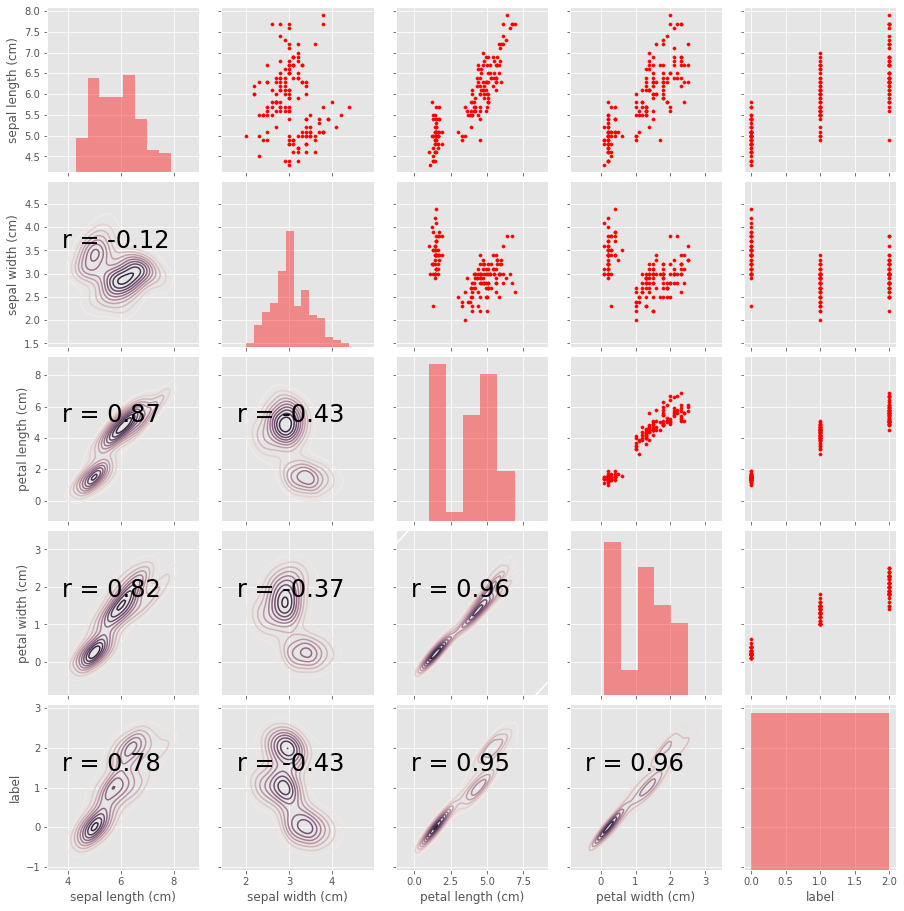

In [125]:
# Step 22

# Generating the pair plot using the seaborn package
import warnings
warnings.filterwarnings('ignore')

# Matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from scipy import stats

# Calculate correlation coefficient
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .6), xycoords=ax.transAxes,
               size = 24)
    
cmap = sns.cubehelix_palette(light=1, dark = 0.1,
                             hue = 0.5, as_cmap=True)

sns.set_context(font_scale=2)

# Pair grid set up
g = sns.PairGrid(df)

# Scatter plot on the upper triangle
g.map_upper(plt.scatter, s=10, color = 'red')

# Distribution on the diagonal
g.map_diag(sns.distplot, kde=False, color = 'red')

# Density Plot and Correlation coefficients on the lower triangle
g.map_lower(sns.kdeplot, cmap = cmap)
g.map_lower(corrfunc);

In [126]:
# Step 23

def standardizeData(dataSet):
    for key, values in dataSet.iteritems():
        mean = dataSet[key].mean()
        std = dataSet[key].std()
        if key != 'label':
            dataSet[key] = (dataSet[key] - mean) / std
    return dataSet

standardizeData = standardizeData(df)

In [130]:
# Step 24

# Splitting the data into Train Set and Test Set
def partition(X,y):
    x_train = np.array(X[int((len(X)+1)):])
    x_test = np.array(X[:int((len(X)+1))])
    y_train = np.array(y[int((len(y)+1)):])
    y_test = np.array(y[:int((len(y)+1))]) 
    return x_train, x_test, y_train, y_test

#separate the target vector and features
def separateTargetVector(dataSet):
    y = dataSet['label'] #target vector
    X = dataSet.drop(columns='label') #features matrix
    return X,y

#a function to split data into partition
#according to the number of folds
def partitionSplit(df, folds):
    s_partition = []
    dfCopy = df
    #set the size for each partiton
    eachPartition = int(df.shape[0] / folds)
    for i in range(folds):
        partition = []
        #going through each partition
        for j in range(eachPartition):
            if(len(partition) < eachPartition):
                value = dfCopy.index[0]
                partition.append(value.tolist())
                dfCopy = dfCopy.drop(value)
        s_partition.append((np.asarray(partition)).tolist())
  
    return s_partition

In [138]:
# Step 25

def mse(Y_test, Y_pred):
    return np.mean(pow((np.array(Y_test) - np.array(Y_pred)),2))

#function for the s-fold validation
def sFold(folds, data, labels, model, error_function, dictionary): 
    avgError = [] 
    splitX = partitionSplit(data, folds)
    minError = 100.0
    
    #loop to choose a partition as validation set
    for i, partition in enumerate(splitX):
        trainSet = list(splitX)
        del(trainSet[i])       #dropping the validation set
        trainSet = sum(trainSet, [])

        testSet = []           #getting the validation set 
        for row in partition:
            testSet.append(row)  #put data in validation set into a new list 
            
        #splitting the data into train and test set
        xTrainValues = []
        yTrainValues = []        
        for trainIndex in trainSet:
            xTrainValues.append(data.loc[trainIndex])
            yTrainValues.append(labels.loc[trainIndex])

        #splitting the validation set data into train and test set
        xTestValues = []
        yTestValues = []
        for testIndex in testSet:
            xTestValues.append(data.loc[testIndex])
            yTestValues.append(labels.loc[testIndex])
    
        #preform prediction using Softmax Regression
        if model == 'Softmax_Regression':
            modelClassifier = Softmax_Regression()
            modelClassifier.fit(np.array(xTrainValues), np.array(yTrainValues), learning_rate = dictionary.get('learning_rate'), epochs=1000, tol = dictionary.get('tol'), regularizer = dictionary.get('regularizer'), lambd = dictionary.get('lambd'), early_stopping=False, validation_fraction=0.1)
            yPredict= modelClassifier.predict(np.array(xTestValues))
            
            #calculating the error using mse score
            if error_function == "mse":
                error = mse(yTestValues, yPredict)
                avgError.append(error)
        
    avgFinalError = sum(avgError)/folds
    if(avgFinalError < minError):
        minError = avgFinalError
        print("Average Error: %f" %avgFinalError)
        print("Lambda: %.4f" %dictionary.get('lambd'))
        print("Tol: %.4f" %dictionary.get('tol'))
        print("Learning Rate: %.4f" %dictionary.get('learning_rate')) 
        print("Regularizer: %s" %dictionary.get('regularizer'))
        print("\n")


#function to pass the hyperparameter into s-fold validation
def dictionary(lambd, tol, learning_rate, regularizer):
    modelArgs = dict()
    #form the dictionary
    for eachLambd in lambd:
        for eachTol in tol:
            for eachLearningRate in learning_rate:
                for eachRegularizer in regularizer:
                    modelArgs = {'lambd' : eachLambd, 'tol' : eachTol, 'learning_rate' : eachLearningRate,'regularizer': eachRegularizer}
                    #use of s-folds
                    sFold(5, X, y, 'Softmax_Regression', 'mse', modelArgs)
                

#get the X data(features without target) and y data(target column)
X,y = separateTargetVector(standardizeData)
                
lambd = [0.1,0.01, 0.001, 0.0001]
tol = [0.001, 0.0001, 0.00001, 0.000001, 0.0000001]
learning_rate = [0.1, 0.01, 0.001]
regularizer = ['l1', 'l2']

dictionary(lambd, tol, learning_rate,regularizer)

Average Error: 0.120000
Lambda: 0.1000
Tol: 0.0010
Learning Rate: 0.1000
Regularizer: l1


Average Error: 0.120000
Lambda: 0.1000
Tol: 0.0010
Learning Rate: 0.1000
Regularizer: l2


Average Error: 0.140000
Lambda: 0.1000
Tol: 0.0010
Learning Rate: 0.0100
Regularizer: l1


Average Error: 0.120000
Lambda: 0.1000
Tol: 0.0010
Learning Rate: 0.0100
Regularizer: l2


Average Error: 0.220000
Lambda: 0.1000
Tol: 0.0010
Learning Rate: 0.0010
Regularizer: l1


Average Error: 0.226667
Lambda: 0.1000
Tol: 0.0010
Learning Rate: 0.0010
Regularizer: l2


Average Error: 0.120000
Lambda: 0.1000
Tol: 0.0001
Learning Rate: 0.1000
Regularizer: l1


Average Error: 0.113333
Lambda: 0.1000
Tol: 0.0001
Learning Rate: 0.1000
Regularizer: l2


Average Error: 0.113333
Lambda: 0.1000
Tol: 0.0001
Learning Rate: 0.0100
Regularizer: l1


Average Error: 0.113333
Lambda: 0.1000
Tol: 0.0001
Learning Rate: 0.0100
Regularizer: l2


Average Error: 0.266667
Lambda: 0.1000
Tol: 0.0001
Learning Rate: 0.0010
Regularizer: l1



Average Error: 0.120000
Lambda: 0.0001
Tol: 0.0010
Learning Rate: 0.1000
Regularizer: l2


Average Error: 0.126667
Lambda: 0.0001
Tol: 0.0010
Learning Rate: 0.0100
Regularizer: l1


Average Error: 0.126667
Lambda: 0.0001
Tol: 0.0010
Learning Rate: 0.0100
Regularizer: l2


Average Error: 0.220000
Lambda: 0.0001
Tol: 0.0010
Learning Rate: 0.0010
Regularizer: l1


Average Error: 0.220000
Lambda: 0.0001
Tol: 0.0010
Learning Rate: 0.0010
Regularizer: l2


Average Error: 0.113333
Lambda: 0.0001
Tol: 0.0001
Learning Rate: 0.1000
Regularizer: l1


Average Error: 0.113333
Lambda: 0.0001
Tol: 0.0001
Learning Rate: 0.1000
Regularizer: l2


Average Error: 0.120000
Lambda: 0.0001
Tol: 0.0001
Learning Rate: 0.0100
Regularizer: l1


Average Error: 0.120000
Lambda: 0.0001
Tol: 0.0001
Learning Rate: 0.0100
Regularizer: l2


Average Error: 0.106667
Lambda: 0.0001
Tol: 0.0001
Learning Rate: 0.0010
Regularizer: l1


Average Error: 0.106667
Lambda: 0.0001
Tol: 0.0001
Learning Rate: 0.0010
Regularizer: l2



In [144]:
# Step 26

X,y = separateTargetVector(df)
xTrain, xTest, yTrain, yTest = partition(X, y)
modelClassifier = Softmax_Regression()
modelClassifier.fit(np.array(xTrain), np.array(yTrain), learning_rate = 0.001, epochs=1000, tol = 0.0000, regularizer = 'l1', lambd = 0.1, early_stopping=False, validation_fraction=0.1)
yPredict = modelClassifier.predict(xTest)
yPredict = np.array(yPredict)

print('Accuracy:', accurary(yTest, yPredict))
print('Confusion Matrix:', confusionMatrix(yTest, yPredict))
print("\n")

ValueError: attempt to get argmax of an empty sequence